<a href="https://colab.research.google.com/github/wordman2/Amazon_Review_Sentiment_Analysis/blob/main/3_Model_Building_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
google_drive_path = "/content/drive/MyDrive/DS/CA2_DM/"
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torchmetrics

In [3]:
import numpy as np
import pandas as pd
import torch
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from torch.utils.data import RandomSampler,SequentialSampler,DataLoader
import torchmetrics
from tqdm import tqdm

# torch.manual_seed(0)
device = torch.device("cpu")
# torch.use_deterministic_algorithms(True)

# 3. Model Building and Evaluation

Building upon the tokenization and preprocessing steps, in this section a BERT model is fine-tuned on to the sentiment analysis task. Therefore, we're going to use the prepared training and test datasets and fine-tune a pretrained DistilBERT and SieBERT model. DistilBERT is smaller and faster than a BERT model by using a compression technique of knowledge distillation [[6]](#6). SieBERT is specificially fined-tuned and evaluated on 15 different sentiment analysis datasets [[7]](#7). The text types ranges from tweets to various reviews. Since SieBERT is fine-tuned on binary sentiment analysis datasets, it requires less training data and less computation demands to attain an similar accuracy scores like a general-purpose language model. \
The following training parameters are applied for fine-tuning both models:
- batch size: 8
- optimizer: Adam
- number epochs: 6
- learning rate: 5e-5
- loss function: BCELoss

<a id="6">[6]</a> Chan, J.YL., Bea, K.T., Leow, S.M.H. et al. State of the art: a review of sentiment analysis based on sequential transfer learning. Artif Intell Rev 56, 749–780 (2023). https://doi.org/10.1007/s10462-022-10183-8

<a id="7">[7]</a> Jochen Hartmann, Mark Heitmann, Christian Siebert, Christina Schamp,
More than a Feeling: Accuracy and Application of Sentiment Analysis,
International Journal of Research in Marketing,
Volume 40, Issue 1,
2023,
Pages 75-87,
ISSN 0167-8116,
https://doi.org/10.1016/j.ijresmar.2022.05.005.
(https://www.sciencedirect.com/science/article/pii/S0167811622000477)


In [4]:
with open(google_drive_path+"data/train.pkl", "rb") as f:
    train_dataset = pickle.load(f)

with open(google_drive_path+"data/test.pkl", "rb") as f:
    test_dataset = pickle.load(f)

# Set up training parameters
num_epochs = 6
learning_rate = 5e-5
batch_size = 8

dataloader_train = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size = batch_size
    )

dataloader_test = DataLoader(
    test_dataset,
    shuffle=True,
    batch_size = batch_size
    )



# Define optimizer and loss function
criterion = torch.nn.BCEWithLogitsLoss() # binary cross entropy


In [4]:
model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)
model.to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate)
training_losses = []
# training loop
for epoch in range(num_epochs):
    training_loss = 0.0
    for i, batch in enumerate(tqdm(dataloader_train), 0):

        # forward pass
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        output = model(input_ids, attention_mask=attention_mask)
        logits = output.logits

        # calculate the loss
        loss = criterion(logits.squeeze(), labels) #squeeze ensures that the logits have the expected shape

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    epoch_loss = training_loss / len(dataloader_train)
    training_losses.append(epoch_loss)
    print("Epoch: ", epoch + 1)
    print("Loss: ", epoch_loss)

    model_path = google_drive_path + f'model_epoch{epoch+1}.pth'
    torch.save(model.state_dict(), model_path)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 93%|█████████▎| 1629/1750 [04:44<00:21,  5.73it/s]


KeyboardInterrupt: ignored

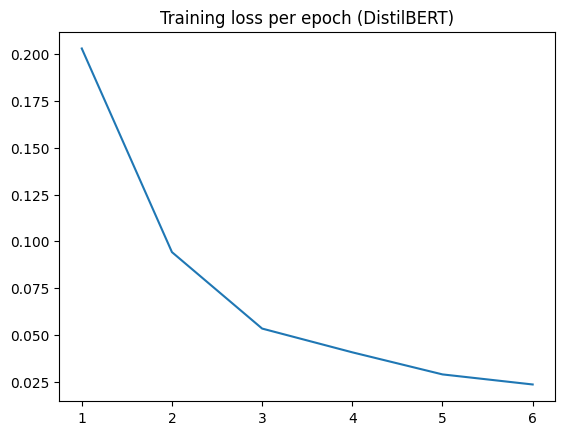

In [ ]:
import matplotlib.pyplot as plt

plt.plot([i+1 for i in range(num_epochs)],training_losses)
plt.title("Training loss per epoch (DistilBERT)")
plt.show()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# SiEBERT
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english", num_labels=1, ignore_mismatched_sizes=True)
model.to(device)

num_epochs = 2
optimizer = AdamW(model.parameters(), lr=learning_rate)

training_losses = []
model.train()
# training loop
for epoch in range(num_epochs):
    training_loss = 0.0
    for i, batch in enumerate(tqdm(dataloader_train), 0):

        # forward pass
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        output = model(input_ids, attention_mask=attention_mask)
        logits = output.logits

        # calculate the loss
        loss = criterion(logits.squeeze(), labels) #squeeze ensures that the logits have the expected shape

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    epoch_loss = training_loss / len(dataloader_train)
    training_losses.append(epoch_loss)
    print("Epoch: ", epoch + 1)
    print("Loss: ", epoch_loss)

    model_path = google_drive_path + f'model_siebert_epoch{epoch+1}.pth'
    torch.save(model.state_dict(), model_path)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at siebert/sentiment-roberta-large-english and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 1024]) in the checkpoint and torch.Size([1, 1024]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1750/1750 [33:32<00:00,  1.15s/it]


Epoch:  1
Loss:  0.5598185062834194


100%|██████████| 1750/1750 [33:32<00:00,  1.15s/it]


Epoch:  2
Loss:  0.5560718783736229


100%|██████████| 1750/1750 [33:32<00:00,  1.15s/it]


Epoch:  3
Loss:  0.5554721876553127


100%|██████████| 1750/1750 [33:30<00:00,  1.15s/it]


Epoch:  4
Loss:  0.5552817675045558


100%|██████████| 1750/1750 [33:28<00:00,  1.15s/it]


Epoch:  5
Loss:  0.5549101926854678


 11%|█         | 195/1750 [03:44<29:42,  1.15s/it]

In [5]:
siebert = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english", num_labels=1, ignore_mismatched_sizes=True)
model_path = google_drive_path + f'model_siebert_epoch2.pth'
model_state_dict = torch.load(model_path)
siebert.load_state_dict(model_state_dict)
siebert.to(device)

model_name = "distilbert-base-uncased"
distilbert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)
model_path = google_drive_path + f'model_epoch6.pth'
distilbert_model_state_dict = torch.load(model_path)
distilbert.load_state_dict(distilbert_model_state_dict)
distilbert.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at siebert/sentiment-roberta-large-english and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 1024]) in the checkpoint and torch.Size([1, 1024]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [13]:
# evaluation
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, AUROC, Specificity
def evaluate_model(model, dataloader_test):
  num_classes = 2
  metrics = [Accuracy(num_classes=num_classes, task="binary").to(device),
             Precision(num_classes=num_classes, task="binary").to(device),
             Recall(num_classes=num_classes, task="binary").to(device),
             F1Score(num_classes=num_classes, task="binary").to(device),
            AUROC(task="binary").to(device),
            Specificity(num_classes=num_classes, task="binary").to(device),
            torchmetrics.ConfusionMatrix(task="binary").to(device)]

  model.eval()
  for batch in tqdm(dataloader_test):
      input_ids, attention_mask, labels = batch
      input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
      output = model(input_ids, attention_mask=attention_mask)
      logits = output.logits
      probabilities = torch.sigmoid(logits.squeeze())
      predicted_labels = (probabilities >= 0.5).int().float()

      for metric in metrics:
          metric.update(predicted_labels, labels)

  metrics = [metric.compute().float() for metric in metrics]
  return metrics

results_siebert = evaluate_model(siebert,dataloader_test)
results_distilbert = evaluate_model(distilbert,dataloader_test)



AttributeError: ignored

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

results = pd.DataFrame([results_distilbert[:-1], results_siebert[:-1]],columns=["Acc", "Prec", "Rec", "F1", "AUC", "Specifity"], index=["DistilBERT",
                                                                                                                                        "SieBERT"])
results = results.applymap(lambda x: x.item())

df = pd.DataFrame(results_distilbert[-1], columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])
sn.heatmap(df, annot=True, cmap="Greys", )
plt.title("Confusion matrix DistilBert")
plt.show()

df = pd.DataFrame(results_siebert[-1], columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])
sn.heatmap(df, annot=True, cmap="Greys", )
plt.title("Confusion matrix Siebert")
plt.show()